In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm as t
from run_adv_diff_copy import run_toy_model

#Change lines below to match name of the directory and names of the files

data_dir = "/mnt/c/Users/laure/Documents/smoking_hot_inverse_problems/src/data/"
namefile_truth = lambda i,j: data_dir + 'sensor_data'+str(i)+'_'+str(j)+'.npy' #measurements noisy wind
namefile_hypot = lambda i,j: data_dir + 'sample_data'+str(i)+'_'+str(j)+'.npy'

#Parameters of the grid
Ntimes = 119
N = 80

In [2]:
def weighted_norm(Sigma_inv, x):
    return x.T@Sigma_inv@x

def compute_posterior(prior, true_source, measurement_array, Sigma_noise, preload_data = None, preload_measurements = None):

    if preload_data is None:
        #Generate random data
        True_measurements = np.reshape(np.load(namefile_truth(*true_source)),(Ntimes,N,N))[measurement_array]
        noise = np.random.multivariate_normal(mean = [0]*n_measurements, cov = Sigma_noise)
        data = True_measurements + noise
    else: 
        data = preload_data
    
    if preload_measurements is None:
        #Will load the matrices from disk
        get_measurements = lambda i,j: np.reshape(np.load(namefile_hypot(i,j)),(Ntimes,N,N))[measurement_array]
    else:
        #Measurements has to be (N,N,N_measurements)
        get_measurements = lambda i,j: preload_measurements[i,j]
  
    Sigma_inv = np.linalg.inv(Sigma_noise)
    posterior = np.zeros((N,N))
    #I'm not sure if this can be vectorized anymore since I have to individually open and close files
    #However, it is not slow
    for i in range(N):
        for j in range(N):
            #Compute prob(data|source is in (i,j))
            #Compute first true observations that would have happened if the source was in (i,j)
            hypothetical_observations = get_measurements(i,j)
            posterior[i,j] = prior[i,j]*np.exp(-1/2 * weighted_norm(Sigma_inv, data-hypothetical_observations))
            # print(data-hypothetical_observations,posterior[i,j])
            # print("norm",weighted_norm(Sigma_inv, data-hypothetical_observations))
            # print("prior",prior[i,j])
    # print('posterior',posterior)
    # plt.figure()
    # plt.imshow(posterior)
    # plt.show()
    s = np.sum(posterior)
    posterior/= s
    return posterior

In [113]:
#Example parameters to run the function
true_source = (40,55) #Specifies the coordinate in the grid where one can find the true source 
#Where in the grid are we making measurements? 
#We specify it with a boolean array of shape [Ntimes, N, N], true if we are making measurements and false if not
#The following example is 10 sensors in the diagonal at all times, giving us 10*10*119 = 1190 measurements
measurement_array = np.zeros((Ntimes, N, N)).astype(bool)
# sensors = [[6*i+(i%3)*8, 6*i] for i in range(1,11)] #
# sensors = [[40,30],[45,30],[50,30],[55,30],[60,30],[65,30],[70,30],[40,35],[40,40],[40,45],[40,50]] #
sensors = [[40,30],[50,30],[60,30],[40,40],[40,50]] #

# sensors = [[10,10],[30,10],[50,10],[70,10],
#            [10,30],[30,30],[50,30],[70,30],
#            [10,50],[30,50],[50,50],[70,50],
#            [10,70],[30,70],[50,70],[70,70]] #
n_measurements = 0
for i in range(Ntimes):
    for sensor in sensors:
        measurement_array[i, sensor[0], sensor[1]] = True
        n_measurements +=1

In [114]:
#Example uniform prior
prior = 1/N**2 * np.ones((N,N))
# print(n_measurements)
# print(sensors,len(sensors)*119)
# print([[6*i+(i%3)*7, 6*i] for i in range(1,11)])

In [152]:
#An example of precomputed measurements: 
# precomputed_data = np.zeros((N,N,n_measurements))
# for i in t(range(N)):
#     for j in range(N):
#         precomputed_data[i,j] = np.reshape(np.load(namefile(i,j)), (Ntimes,N,N))[measurement_array]
# precomputed_data = np.zeros((N,N,n_measurements))
n = N  # GRID DIMENSION: square domain
T = Ntimes # number of time steps, integer
num_faces = 2*N**2 + 2*N
num_cells = N**2            
S = np.array([1.0])         # List: source strengths
S_loc = np.array([[true_source[0]/N, true_source[1]/N]]) #np.array([[0.5, 0.5]]) # List: source locations in 1x1 domain
#S_loc = np.array([[0.1, 0.6]]) #np.array([[0.5, 0.5]]) # List: source locations in 1x1 domain

sense_t = list(np.arange(1,Ntimes+1))      # List: sensor output times (integer times)
sense_loc = [[i] for i in sensors] # List: sensor locations

# modify if velocity field/diff_coeff are different than default
# u_vel = -4.0
# v_vel = -6.0
velocity_field = -np.ones(num_faces)*1.0+np.random.randn(num_faces)*0.001
# print(S_loc[:,0])
# print(S_loc)
#D = 10.0
diff_coeff = np.ones(num_cells)

# generate windy data for this, saved as sensor_data*_*.npy
#run_toy_model(n, S, S_loc, sense_t, sense_loc, velocity_field=velocity_field, diff_coeff=diff_coeff, create_gif=False)
run_toy_model(n, S, S_loc, sense_t, sense_loc, velocity_field=velocity_field, create_gif=False)


In [116]:
sense_loc

[[[40, 30]], [[50, 30]], [[60, 30]], [[40, 40]], [[40, 50]]]

In [117]:
precomputed_measurements = np.zeros((N,N,n_measurements))
for i in t(range(N)):
    for j in range(N):
        precomputed_measurements[i,j] = np.reshape(np.load(namefile_hypot(i,j)),(Ntimes,N,N))[measurement_array]

  0%|          | 0/80 [00:00<?, ?it/s]

In [150]:
sigma = 0.05
Sigma_noise = sigma**2*np.eye(n_measurements) #Assuming here that all the sensors are independent and with the same noise

In [153]:
posterior = compute_posterior(prior = prior, true_source=true_source, measurement_array=measurement_array, Sigma_noise=Sigma_noise, preload_measurements=precomputed_measurements) #, 
                 #preload_data= precomputed_data)

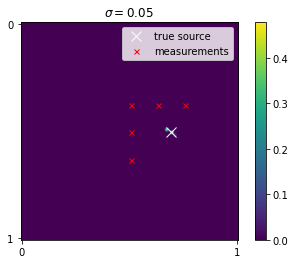

In [155]:
plt.imshow(posterior)
plt.title(r'$\sigma=0.05$')
plt.plot([true_source[1]],true_source[0],'x', color = 'white', markersize = 10, label = 'true source')
plt.plot(*np.array(sensors).T, 'x', color = 'red', markersize = 5, label = 'measurements')
plt.xticks([0,79], [0,1])
plt.yticks([0,79], [0,1])

plt.colorbar()
plt.legend()
plt.savefig("figures/wind_setup.png")

In [143]:
def get_mean(distribution):
    # normalization = (N*(N-1)/2)
    # print( [i%N + 1 for i in range(N**2)] )
    # print( [np.floor(i/N)+1 for i in range(N**2)] )
    # x_coord = np.sum(distribution * [i%N + 1 for i in range(N**2)]/normalization)
    # y_coord = np.sum(distribution * [np.floor(i/N)+1 for i in range(N**2)]/normalization)
    coord_matx = np.zeros((N,N))
    coord_maty = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            coord_matx[i,j] = i
            coord_maty[i,j] = j
    x_coord = np.sum(distribution * coord_matx)
    y_coord = np.sum(distribution * coord_maty)
    # print(x_coord,y_coord)
    return (x_coord,y_coord)

def L2(coord1, coord2):
    # 2 norm for now
    return np.sqrt( (coord1[0]-coord2[0])**2 + (coord1[1]-coord2[1])**2)
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
def dTV(p,q):
    return 1/2.0*np.sum(abs(p-q))
def dH(p,q):
    return np.linalg.norm(np.sqrt(p)-np.sqrt(q),ord='fro')/np.sqrt(2)

number_of_batches     = 1000
wind_levels           = [i for i in np.arange(0.0,1,0.1)]
L2dist_from_posterior = np.zeros((len(wind_levels),number_of_batches))
dTV_                  = np.zeros((len(wind_levels),number_of_batches))
dH_                   = np.zeros((len(wind_levels),number_of_batches))


denominator = np.zeros((len(wind_levels),1))
true_distribution = np.zeros((N,N))
true_distribution[true_source[0],true_source[1]] = 1

for batch in t(range(number_of_batches)):
    for num, wind_noise in enumerate(wind_levels):
        velocity_field = -np.ones(num_faces)+np.random.randn(num_faces)*wind_noise
        run_toy_model(n, S, S_loc, sense_t, sense_loc, velocity_field=velocity_field, create_gif=False)
        posterior = compute_posterior(prior = prior, true_source=true_source, measurement_array=measurement_array, 
                                    Sigma_noise=Sigma_noise, preload_measurements=precomputed_measurements)
        # compute mean
        mean_val = get_mean(posterior)
        
        # compute distance from true 
        dist = L2(mean_val,true_source)
        L2dist_from_posterior[num,batch] += dist
        if abs(mean_val[0])>1e-3 or abs(mean_val[1])>1e-3:
            denominator[num] += 1
        div1 = dTV(posterior,true_distribution)
        div2 = dH(true_distribution,posterior)
        dTV_[num,batch] = div1
        dH_[num,batch] = div2
        # plt.imshow(posterior)
        # plt.title(r'$\sigma='+str(wind_noise)+'% wind noise')
        # plt.plot(true_source[1], true_source[0],'x', color = 'white', markersize = 10, label = 'true source')
        # plt.plot(mean_val[1],mean_val[0],'x',color='yellow',markersize = 10, label="mean")
        # plt.plot(*np.array(sensors).T, 'x', color = 'red', markersize = 5, label = 'measurements')
        # plt.xticks([0,79], [0,1])
        # plt.yticks([0,79], [0,1])
        # plt.colorbar()
        # plt.legend()
        # plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [144]:
# l2t = np.copy(L2dist_from_posterior)
# l2t[l2t==0] = np.nan
# print(L2dist_from_posterior)
# print(denominator)

In [145]:
# process data

# L2dist_from_posterior /= denominator
# dTV_                   /= denominator
# dH_                   /= denominator
# L2dist_from_posterior_t  = np.trim_zeros(L2dist_from_posterior)
# dTV_t                    = np.trim_zeros(dTV_)
# dH_t                     = np.trim_zeros(dH_)
L2dist_from_posterior[L2dist_from_posterior == 0]  = np.nan
dTV_[dTV_ == 0]                                    = np.nan
dH_[dH_ == 0]                                      = np.nan


/tmp/ipykernel_5137/3798182724.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  snr = [1/i for i in wind_levels]


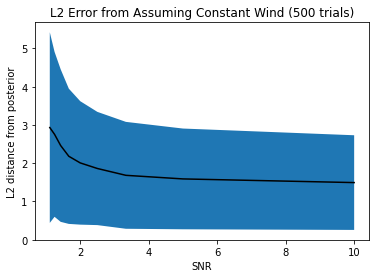

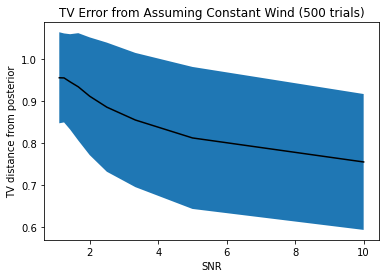

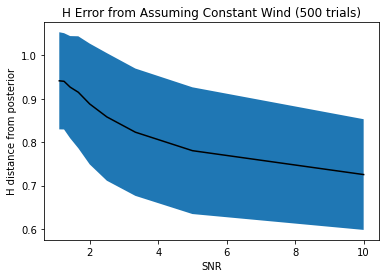

In [146]:
snr = [1/i for i in wind_levels]
y1 = np.nanmean(L2dist_from_posterior,axis=1)
e1 = np.sqrt(np.nanvar(L2dist_from_posterior,axis=1))
plt.figure()
plt.plot(snr,y1,'k')
plt.fill_between(snr,y1-e1,y1+e1)
plt.xlabel("SNR")
plt.ylabel("L2 distance from posterior")
plt.title("L2 Error from Assuming Constant Wind (500 trials)")
plt.savefig("figures/L2.png")

y2 = np.nanmean(dTV_,axis=1)
e2 = np.sqrt(np.nanvar(dTV_,axis=1))
plt.figure()
plt.plot(snr,y2,'k')
plt.fill_between(snr,y2-e2,y2+e2)
plt.xlabel("SNR")
plt.ylabel("TV distance from posterior")
plt.title("TV Error from Assuming Constant Wind (500 trials)")
plt.savefig("figures/TV.png")

y3 = np.nanmean(dH_,axis=1)
e3 = np.sqrt(np.nanvar(dH_,axis=1))
plt.figure()
plt.plot(snr,y3,'k')
plt.fill_between(snr,y3-e3,y3+e3)
plt.xlabel("SNR")
plt.ylabel("H distance from posterior")
plt.title("H Error from Assuming Constant Wind (500 trials)")
plt.savefig("figures/H.png")